In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display
import matplotlib
from matplotlib import pyplot as plt
import importlib
from datetime import timedelta

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

#Path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

In [2]:
#For GPUOcean
from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils
from demos.realisticSimulations import norkyst_plotting

#For Opendrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.oceandrift import OceanDrift

#For OceanParcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, Field

In [3]:
%cuda_context_handler gpu_ctx

In [65]:
def simulate_parcels(source_url, output_filename, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    filenames = {'U' : source_url, 'V': source_url}
    dimensions = {'lat': 'lat','lon': 'lon','time': 'time'}

    if velocity_average: 
        variables = {'U': 'ubar', 'V': 'vbar'}
    else:
        variables = {'U': 'u', 'V': 'v'}

    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, interp_method = 'cgrid_velocity')
    
    if wind_drift_percentage:
        Uwind = Field.from_netcdf(source_url, ('U', 'Uwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Vwind = Field.from_netcdf(source_url, ('V', 'Vwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Uwind.set_scaling_factor(wind_drift_percentage)
        Vwind.set_scaling_factor(wind_drift_percentage)
        fieldset = FieldSet(U = fieldset.U+ Uwind,V = fieldset.V+ Vwind)

    pset = ParticleSet.from_list(fieldset = fieldset, pclass = JITParticle, lon=lon, lat=lat)
    output_file = pset.ParticleFile(name = output_filename, outputdt = timedelta(minutes=15))

    pset.execute(AdvectionRK4, runtime = timedelta(hours = hours), dt = timedelta(minutes=5), output_file = output_file)

    output_file.export()

In [74]:
def simulate_opendrift(source_url, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    reader_norkyst = reader_netCDF_CF_generic.Reader(source_url)
    o = OceanDrift(loglevel=20)
    
    if velocity_average:
        reader_norkyst.variable_mapping['x_sea_water_velocity'] = 'ubar'
        reader_norkyst.variable_mapping['y_sea_water_velocity'] = 'vbar'
    
    o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity', 'x_wind', 'y_wind'])
    #o.add_readers_from_list(source_url)
    #print(o.required_variables)
    #for n in range(len(source_url)):
    #    readers=reader_netCDF_CF_generic.Reader(source_url[n])
    #    o.add_reader(readers, variables=['x_sea_water_velocity', 'y_sea_water_velocity', 'x_wind', 'y_wind'])
        
    o.seed_elements(lon= lon, lat=lat, radius=1, number=1, time=reader_norkyst.start_time, wind_drift_factor = wind_drift_percentage)
    
    o.set_config('drift:scheme', 'runge-kutta4')
    
    o.run(duration = timedelta(hours=hours), time_step = 300, time_step_output = 900)
    
    return o

In [70]:
def initlonlat2initgpuocean(opendrift_obj, X_norkyst, Y_norkyst, lon, lat, num_cells_x, num_cells_y, res = 800):
    #Finding tentative x,y(not for a specific domain)
    x, y = opendrift_obj.lonlat2xy(lon,lat)

    #Given x,y, num_cells_x, num_cells_y and resolution: specify domain in gpuocean
    x0, x1 = x//res - num_cells_x, x//res + num_cells_x 
    y0, y1 = y//res - num_cells_y, y//res + num_cells_y
    
    print(x0)
    #Find new x,y in gpuocean coordinates for initial position
    xinit = x - X[int(x0) + 2]
    yinit = y- Y[int(y0) + 2]
    
    return xinit, yinit, int(x0), int(x1), int(y0), int(y1)

In [7]:
#Motsatt vei?
def gpuocean2lonlat(opendrift_obj, X_norkyst, Y_norkyst, x, y, x0, y0):
    x = x + X_norkyst[x0+2]
    y = y + Y_norkyst[y0+2]
    
    lon, lat = opendrift_obj.xy2lonlat(x,y)

    return lon, lat

In [72]:
def opendriftObj2gpuoceanObs(opendrift_obj,X_norkyst, Y_norkyst, x0, x1,y0,y1, res = 800,  land_mask = None):
    t = opendrift_obj.get_time_array()[1]
    for i in range(len(t)):
        t[i] = t[i].total_seconds()
    t = np.array(t)

    lon, lat = opendrift_obj.get_lonlats()
    x,y = opendrift_obj.lonlat2xy(lon,lat)
    
    x = x - X_norkyst[x0 +2] # in m
    y = y- Y_norkyst[y0 +2] # in m

    #TODO: Remove drifters ouside the domain

    nx = (x1-x0-4) #num_cells
    ny = (y1-y0-4) #num_cells
    
    obs = Observation.Observation(domain_size_x = nx*res,
                                    domain_size_y = ny*res,
                                    nx=x1-x0-4, ny=y1-y0-4, land_mask = land_mask)

    obs.add_observations_from_arrays(t,x,y) #x,y i m fra origin i gpuocean ?
    
    return obs

In [9]:
def parcelsFile2gpuoceanObs(filename, opendrift_obj, X_norkyst, Y_norkyst, x0, x1, y0,y1, res = 800, land_mask = None):
    pfile = Dataset(filename)
    t = pfile.variables['time'][0,:]
    lon = np.ma.filled(pfile.variables['lon'], np.nan)
    lat = np.ma.filled(pfile.variables['lat'], np.nan)
    pfile.close()

    x,y = opendrift_obj.lonlat2xy(lon,lat)
    
    x = x - X_norkyst[x0 +2] # in m
    y = y- Y_norkyst[y0 +2] # in m
    
    #TODO: Remove drifters ouside the domain

    nx = (x1-x0-4) #num_cells
    ny = (y1-y0-4) #num_cells
    
    obs = Observation.Observation(domain_size_x = nx*res,
                                    domain_size_y = ny*res,
                                    nx=x1-x0-4, ny=y1-y0-4, land_mask = land_mask)
    
    obs.add_observations_from_arrays(t,x,y) #x,y i m fra origin i gpuocean ?
    
    return obs

In [10]:
#Simulating gpu-ocean run OBS: only trajectory output
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0
     }

outfolder = 'deterministic_forecast_test'

def simulate_gpuocean_deterministic(source_url, domain, initx, inity, erode_land, sim_args,rescale=0,observation_type = dautils.ObservationType.UnderlyingFlow, outfolder = None, start_forecast_hours = 0, forecast_duration = 23 ):
    
    end_forecast_hours = start_forecast_hours + forecast_duration
    
    #Create simulator
    data_args = NetCDFInitialization.getInitialConditions(source_url, domain[0], domain[1], domain[2],domain[3] , 
                     timestep_indices = None, erode_land = erode_land, download_data = False)
    
    if rescale:
        data_args = NetCDFInitialization.rescaleInitialConditions(data_args, scale=rescale)

    importlib.reload(CDKLM16)
    sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))
    
    #Forecast
    observation_args = {'observation_type': observation_type,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                   }

    trajectory_forecast = Observation.Observation(**observation_args)

    if outfolder is not None:
        out_folder = os.path.abspath(outfolder)
        os.makedirs(out_folder, exist_ok=True)
        trajectory_forecast_filename = 'trajectory_forecast_'+str(start_forecast_hours)+'_to_'+str(end_forecast_hours)+'.pickle'
        trajectory_forecast_path = os.path.join(out_folder, trajectory_forecast_filename)
    
    #Drifters
    #Assumes initx, inity same format/shape
    if type(initx) is not list:
        initx = [initx]
        inity = [inity]
    
    num_drifters = len(initx)
    
    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, 
                                                     boundaryConditions = sim.boundary_conditions,
                                                     domain_size_x = trajectory_forecast.domain_size_x,
                                                     domain_size_y = trajectory_forecast.domain_size_y,
                                                     gpu_stream = sim.gpu_stream)
    
    drifter_pos_init = np.array([initx, inity]).T
    
    #Run simulation
    num_total_hours = end_forecast_hours
    
    five_mins_in_an_hour = 12
    sub_dt = 5*60 # five minutes
    
    progress = Common.ProgressPrinter(5)
    pp = display(progress.getPrintString(0), display_id=True)

    for hour in range(num_total_hours):
        
        if hour == start_forecast_hours:
            # Attach drifters
            drifters.setDrifterPositions(drifter_pos_init)
            sim.attachDrifters(drifters)
            trajectory_forecast.add_observation_from_sim(sim)
        
        for mins in range(five_mins_in_an_hour):
            t = sim.step(sub_dt)
            if hour >= start_forecast_hours:
                trajectory_forecast.add_observation_from_sim(sim)
        
        pp.update(progress.getPrintString(hour/(end_forecast_hours-1)))
    
    if outfolder is not None:
        trajectory_forecast.to_pickle(trajectory_forecast_path)
    
    return trajectory_forecast


In [11]:
from SWESimulators import PlotHelper

def getVfromReference(source_url,domain, hour):
    x0,x1,y0,y1 = domain
    
    ncfile = None
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0:y1, x0:x1]
        eta = ncfile.variables['zeta'][hour, y0:y1, x0:x1]
        hu = ncfile.variables['ubar'][hour, y0:y1, x0:x1]
        hv = ncfile.variables['vbar'][hour, y0:y1, x0:x1]
        
        hu = hu * (H_m + eta)
        hv = hv * (H_m + eta)
        
    except Exception as e:
        raise e
    finally:
        ncfile.close()
        
    H_m.mask = eta.mask
    
    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = eta.mask
    return V

In [61]:
def createForecastCanvas(observation, background= False, url=None, domain = None,  zoom = 1, hour=23):
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111)

    xmax = observation.domain_size_x
    ymax = observation.domain_size_y

    extent=np.array([0, xmax, 0, ymax]) 

    if background:
        assert(url is not None and domain is not None), 'Url or domain missing for background'
        v_cmap = plt.cm.YlOrRd

        land_color = 'grey'
        v_cmap.set_bad(land_color, alpha = 1.0)
        V = getVfromReference(url,domain, hour)

        ax.imshow(V, origin = 'lower', extent = extent, cmap = v_cmap, vmin = 0, vmax = 0.6)
    else:
        ax.imshow(observation.land_mask, origin="lower", 
              extent=extent, cmap='binary')

    ax.set_xlim([xmax*(1/2 - 1/2. * 1/zoom),xmax*(1/2 +1/2. * 1/zoom)])
    ax.set_ylim([ymax*(1/2 - 1/2. *1/zoom),ymax*(1/2 + 1/2. * 1/zoom)])

    return ax


In [62]:
def plotAllDrifters(obs, drifter_ids=None,background = False, url = None, color_id = 2, domain = None, ax = None, start = 0, end = 23, zoom = 1):
    """background: True if velocity field as background(absolute value of velocity). Default is False. 
                Opendrift/Norkyst800 used currently. GPUOcean?
        url needed if background = True, domain needed if background = True
    """
    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark blue grey'],
        ['xkcd:viridian', 'xkcd:foam green','xkcd:light blue grey'],
        ['g', 'xkcd:foam green', 'xkcd:dark grey green']
    ]
    colors = color_combinations[0]
    
    if drifter_ids is None:
        drifter_ids = np.arange(obs.get_num_drifters(ignoreBuoys=True))
    
    num_drifters = len(drifter_ids)
    
    drifter_paths = [None]*num_drifters

    forecast_start_t = 0
    forecast_end_t = end*3600

    for i in range(num_drifters):
        drifter_paths[i] = obs.get_drifter_path(drifter_ids[i], forecast_start_t, forecast_end_t, in_km = False)

    if ax is None:
        ax = createForecastCanvas(obs, background = background,url = url,domain = domain, hour = end, zoom = zoom)
        
    for drifter_path in drifter_paths:
        for path in drifter_path:
            ax.plot(path[:,0], path[:,1], color=colors[color_id], zorder=5)

            # Mark start and end of true path
            start_pos = drifter_path[0][0,:]
            end_pos   = drifter_path[-1][-1,:]

            circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                   20, color = 'xkcd:scarlet',
                                                   fill=False, zorder=10)
            ax.add_patch(circ_start)
            ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)


In [49]:
#source_url =  ['/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc', 
#               '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc', 
#               '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc'
#              ]
#purl = '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/*'
#source_url = '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'
#Save X, Y(dimensions) from netcdf file from norkyst800
#ncfile = Dataset(url)
#X = ncfile.variables['X'][:]
#Y = ncfile.variables['Y'][:]
#ncfile.close()

#Create OpendriftObject with norkys data to access coordinate-change lonlat2xy
#reader_norkyst = reader_netCDF_CF_generic.Reader(url)
#o = OceanDrift(loglevel=50)
#o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity'])

#lon, lat = 14.1,69.4
#lon, lat = 4.9, 60.0
#lon, lat = 9.2, 63.9
#hours = 23

09:54:10 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
09:54:10 INFO: Opening file with Dataset


In [50]:

#o1 = simulate_opendrift(source_url, lat, lon, 0.0, True, hours) #no wind, average velocity


09:54:10 INFO: OpenDriftSimulation initialised (version 1.2.3)
09:54:10 INFO: Config validation OK
09:54:10 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
09:54:13 INFO: Using existing reader for land_binary_mask
09:54:13 INFO: All points are in ocean
09:54:13 INFO: 2019-07-16 00:00:00 - step 1 of 276 - 1 active elements (0 deactivated)
09:54:13 INFO: 2019-07-16 00:05:00 - step 2 of 276 - 1 active elements (0 deactivated)
09:54:13 INFO: 2019-07-16 00:10:00 - step 3 of 276 - 1 active elements (0 deactivated)
09:54:13 INFO: 2019-07-16 00:15:00 - step 4 of 276 - 1 active elements (0 deactivated)
09:54:13 INFO: 2019-07-16 00:20:00 - step 5 of 276 - 1 active elements (0 deactivated)
09:54:13 INFO: 2019-07-16 00:25:00 - step 6 of 276 - 1 active elements (0 deactivated)
09:54:13 INFO: 2019-07-16 00:30:00 - step 7 of 276 - 1 active elements (0 deactivated)
09:54:13 INFO: 2019-07-16 00:35:00 - step 8 of

09:54:15 INFO: 2019-07-16 07:30:00 - step 91 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 07:35:00 - step 92 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 07:40:00 - step 93 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 07:45:00 - step 94 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 07:50:00 - step 95 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 07:55:00 - step 96 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 08:00:00 - step 97 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 08:05:00 - step 98 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 08:10:00 - step 99 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 08:15:00 - step 100 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 08:20:00 - step 101 of 276 - 1 active elements (0 deactivated)
09:54:15 INFO: 2019-07-16 08:2

09:54:16 INFO: 2019-07-16 15:15:00 - step 184 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 15:20:00 - step 185 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 15:25:00 - step 186 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 15:30:00 - step 187 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 15:35:00 - step 188 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 15:40:00 - step 189 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 15:45:00 - step 190 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 15:50:00 - step 191 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 15:55:00 - step 192 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 16:00:00 - step 193 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-07-16 16:05:00 - step 194 of 276 - 1 active elements (0 deactivated)
09:54:16 INFO: 2019-0

In [51]:
#initx, inity, x0,x1, y0,y1 = initlonlat2initgpuocean(o, X, Y, lon, lat, 50,50)
#o1obs = opendriftObj2gpuoceanObs(o1, X, Y, x0, x1,y0,y1)

In [52]:
#domain = [x0,x1,y0,y1]
#gpuobs = simulate_gpuocean_deterministic(source_url, domain, initx, inity, erode_land = 1, sim_args = sim_args, outfolder = None, forecast_duration = hours )

'0% [##############################] 100%. Total: 37s, elapsed: 37s, remaining: 0s'

In [53]:
#simulate_parcels(purl, 'parcels_ex.nc', lat,lon,0.0,True,hours) #no wind, average velocity

In [54]:
#pobs = parcelsFile2gpuoceanObs('parcels_ex.nc', o, X, Y, x0, x1, y0,y1)

In [55]:
#gpuobs2 = simulate_gpuocean_deterministic(source_url, domain, initx, inity,rescale = 2, erode_land = 1, sim_args = sim_args, outfolder = None, forecast_duration = 23 )

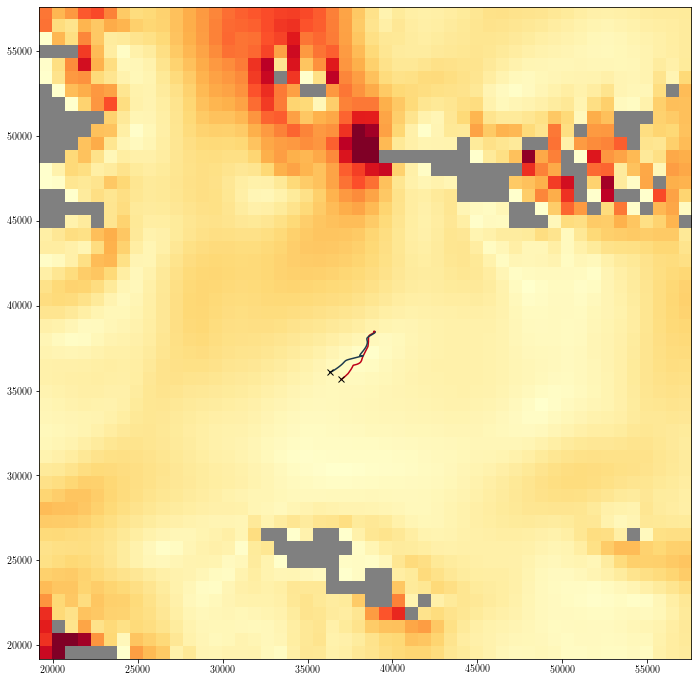

In [63]:
#%matplotlib inline
#colors= ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark blue grey']
#ax = createForecastCanvas(gpuobs,background = True, url = url, domain = domain, zoom = 2)
#plotAllDrifters(gpuobs, ax= ax, end = hours, color_id = 0)
#plotAllDrifters(gpuobs2, ax= ax, end = 23, color_id = 1) #Hmm.....strange, må teste flere eksempler
#plotAllDrifters(pobs, ax = ax, end = hours, color_id = 1)
#plotAllDrifters(o1obs, ax=ax, end = hours, color_id = 2)
#REMARK: Different landmask here and in Opendrift. Opendrift is actually stranded.